In [1]:
!nvidia-smi

Thu Dec  9 13:04:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 81%   74C    P2   338W / 350W |  13057MiB / 24267MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    On   | 00000000:21:00.0 Off |                  Off |
| 30%   

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

batch_size = 128


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


#### Here we shall plot the number of samples in each class.
1. In CIFAR10 dataset the samples are balanced at 5000 samples per class.

We will also define a function long tail that shall convert the balanced dataset\
into an unbalanced one given a dataset imbalance factor lamda. we use an exponential\
decaying function where the the distribution sampling strategy is defined using a power law function

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_data_distribution(dataset, keyname="no name"):
    classes = dataset.classes
    dataset_elems = len(classes)*[0]
    for image, label in dataset:
        dataset_elems[label]+=1
    plt.bar(list(classes), dataset_elems)
    plt.title(keyname)
    plt.show()

#### This function will create a long tail dataset based on a power law distribution

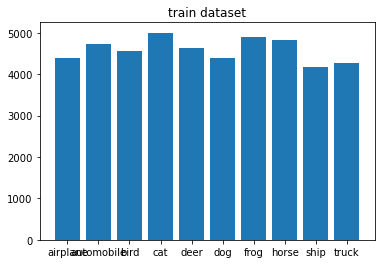

In [7]:
import random
def long_tail(dataset, lamda=1):
    num_classes = len(dataset.classes)
    class_indices = list(range(num_classes))
    random.shuffle(class_indices)
    class_probs = [lamda ** x for x in class_indices]
    select_list = []
    for i, (img, label) in enumerate(dataset):
        if np.random.binomial(1, class_probs[label]):
            select_list.append(i)
    dataset.data=dataset.data[np.array(select_list)]
    dataset.targets=list(dataset.targets[x] for x in select_list)
    return dataset


imabalanced_trainset = long_tail(trainset, lamda = 0.98)
show_data_distribution(imabalanced_trainset, keyname="train dataset")


### Traininig Loop for 1 epoch
In the training loop, we will be providing the optimizer, model,\
dataloader and the criterion i.e the loss function. We shall\
calculate a running loss that averages over the entire epoch and logs the same

In [8]:
def train(trainloader, optimizer, net, criterion, epoch):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            pass

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss = (running_loss*i + loss.item())/(i + 1)

    print("Finished Training Epoch :", epoch, " With the running loss : ", running_loss)
    return net

### Testing loop

In [9]:
def test(testloader, net):
    net.eval()
    output_logs = []
    label_logs = []
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.cuda()
        else:
            pass

        labels = labels.numpy()
        outputs = torch.argmax(net(inputs), dim=1).cpu().detach().numpy()
        output_logs.append(outputs)
        label_logs.append(labels)
    print("Finished testing")
    return (np.concatenate(output_logs, axis=0), np.concatenate(label_logs, axis=0))

### Performance metrics
In the following function we shall feed all the outputs and the labels\
and the get metrics function shall return the following metrics of performance\
1. precision score class wise
2. max precision accross all class epochwise
3. min precision accross all class epochwise
4. mean precision *unweighted
5. recall score class wise
6. max recall accross all class epochwise
7. min recall accross all class epochwise
8. mean recall *unweighted
8. accuracy accross all class epochwise

In [10]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def get_metrics(outputs, labels):
    precision = precision_score(labels, outputs, average=None)
    max_precision = np.max(precision)
    min_precision = np.min(precision)
    mean_precision = np.mean(precision)
    
    recall = recall_score(labels, outputs, average=None)
    max_recall = np.max(recall)
    min_recall = np.min(recall)
    mean_recall = np.mean(recall)
    
    accuracy = accuracy_score(labels, outputs)
    return {
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "max_precision": max_precision,
            "mean_precision": mean_precision,
            "min_precision": min_precision,
            "max_recall": max_recall,
            "mean_recall": mean_recall,
            "min_recall": min_recall
            }

## Master loop
This loop will do one epoch of training, testing and generate the logs for the latter to be fed ti the metrics function to get us our metrics as discussed above

In [11]:
def loop(trainloader, testloader, net, optimizer, criterion, epochs=50):
    logs = []
    for i in range(epochs):
        net = train(trainloader, optimizer, net, criterion, epoch=i)
        outputs, labels = test(testloader, net)
        metrics = get_metrics(outputs, labels)
        logs.append(metrics)
    return logs

## Lets plot everything
For all the metrics generated for every epoch of the model and for the metrics calculated for every class on the validation set,\
we shall plot them out

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plot_log(logs, lamda, classes, num_classes=10):
    precision = [x['precision'] for x in logs]
    recall = [x['recall'] for x in logs]
    accuracy = [x['accuracy'] for x in logs]

    len_logs = len(accuracy)

    max_precision = [x['max_precision'] for x in logs]
    min_precision = [x['min_precision'] for x in logs]
    mean_precision = [x['mean_precision'] for x in logs]

    max_recall = [x['max_recall'] for x in logs]
    min_recall = [x['min_recall'] for x in logs]
    mean_recall = [x['mean_recall'] for x in logs]

    plt.plot(list(range(len(max_precision))), max_precision, label = "max_precision")
    plt.plot(list(range(len(min_precision))), min_precision, label = "min_precision")
    plt.plot(list(range(len(mean_precision))), mean_precision, label = "mean_precision")

    plt.plot(list(range(len(max_recall))), max_recall, label = "max_recall")
    plt.plot(list(range(len(min_recall))), min_recall, label = "min_recall")
    plt.plot(list(range(len(mean_recall))), mean_recall, label = "mean_recall")

    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.title(' min mean and max precision and recalls for class imbalance rate  '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()


    precision = np.array(precision)
    recall = np.array(recall)
    for i in range(num_classes):
        plt.plot(list(range(len_logs)), precision[:, i].tolist(), label = classes[i])
        
    plt.xlabel('Epochs')
    plt.ylabel('Precision classwise')
    plt.title('Class wise precision for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()

    for i in range(num_classes):
        plt.plot(list(range(len_logs)), recall[:, i].tolist(), label = classes[i])

    plt.xlabel('Epochs')
    plt.ylabel('Recall classwise')
    plt.title('Class wise recall for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(list(range(len(accuracy))), accuracy, label = "accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.title('Class wise accuracy for lamda = '+ str(lamda))
    plt.legend()
    plt.show()
    plt.close()

## Benchmark models
Here we have 2 candidate models:
    1. ResNet-18 
    2. ResNet-34
We shall primarily use the latter since it is the clossest to the ResNet32 model used by\
Harikrishna et al in their paper "Training over parameterised model..."

In [13]:
class Resnet18cifar(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.resnet18 = torch.hub.load('pytorch/vision:v0.8.0', 'resnet18', pretrained=pretrained)
        self.base = torch.nn.Sequential(*(list(self.resnet18.children())[:-1]))
        self.fc = torch.nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.base(x)
        x = x.reshape((-1, 512))
        x = self.fc(x)
        return x

class Resnet34cifar(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.resnet34 = torch.hub.load('pytorch/vision:v0.8.0', 'resnet34', pretrained=pretrained)
        self.base = torch.nn.Sequential(*(list(self.resnet34.children())[:-1]))
        self.fc = torch.nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.base(x)
        x = x.reshape((-1, 512))
        x = self.fc(x)
        return x

In [14]:
def tabulate_metrics(logs):
    precision = [x['precision'] for x in logs]

    recall = [x['recall'] for x in logs]

    accuracy = [x['accuracy'] for x in logs]
    print("MAX ACCURACU [E] ", max(accuracy))

    len_logs = len(accuracy)

    max_precision = [x['max_precision'] for x in logs]
    
    min_precision = [x['min_precision'] for x in logs]
    mean_precision = [x['mean_precision'] for x in logs]
    print("MAX MEAN PRECISION [E] ", max(mean_precision))


    max_recall = [x['max_recall'] for x in logs]

    min_recall = [x['min_recall'] for x in logs]
    mean_recall = [x['mean_recall'] for x in logs]
    print("MAX MEAN RECALL [E] ", max(mean_recall))

    maxEC_p = max([x['max_precision'] for x in logs])
    maxEminC_r_at_max_pEC = max([min_recall[index] for index, elem in enumerate(max_precision) if elem == maxEC_p])
    print("max E min C recall @ max E, C precision is :  ", maxEminC_r_at_max_pEC)

    maxEC_r = max([x['max_recall'] for x in logs])
    maxEminC_p_at_max_rEC = min([min_precision[index] for index, elem in enumerate(max_recall) if elem == maxEC_r])
    print("max E min C precision @ max E, C recall is :  ", maxEminC_p_at_max_rEC)
    
    return


## RESNET 34 on CIFAR 10, training from scratch

Files already downloaded and verified
Files already downloaded and verified
============================== showing data distribution for λ =  0.6 ==============================


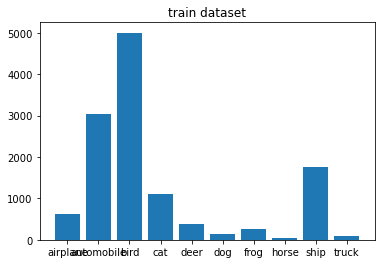

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


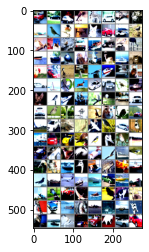

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


automobile automobile automobile  bird   cat automobile   cat  bird  ship  bird  bird airplane   cat automobile automobile  bird  bird  deer  bird automobile  ship   cat  bird  bird  ship automobile  bird  bird airplane  deer  ship   cat  bird automobile  bird  bird  bird  ship  ship   cat automobile  ship  bird  deer automobile automobile  bird  ship   cat  bird  ship  ship  bird  bird automobile automobile automobile  bird  bird  bird  bird   cat  bird automobile airplane automobile  bird  bird airplane  bird automobile  bird  ship automobile automobile  bird  bird  bird  bird  ship automobile  bird  bird  bird   cat  bird  ship  bird  bird   cat  ship  bird automobile  frog automobile  ship  bird  ship airplane  ship  ship automobile  ship  bird airplane  bird automobile  bird  ship   cat   cat  bird   cat automobile  ship   cat airplane  deer  ship   dog   cat  ship   cat automobile automobile   cat automobile automobile
length of trainset 12424
Finished Training Epoch : 0  With th

/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 1  With the running loss :  1.2332115641662054
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 2  With the running loss :  1.1115740762681372
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 3  With the running loss :  1.052066625989213
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 4  With the running loss :  1.0064681427819389
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 5  With the running loss :  0.9784965679353598
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 6  With the running loss :  0.9303694105878169
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 7  With the running loss :  0.9216587908413946
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 8  With the running loss :  0.880069220552639
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 9  With the running loss :  0.8571124721546562
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 10  With the running loss :  0.8459692049999626
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 11  With the running loss :  0.8343082733300268
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 12  With the running loss :  0.8097182834634975
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 13  With the running loss :  0.8396504606519427
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 14  With the running loss :  0.7989807548571605
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 15  With the running loss :  0.7834678821417749
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 16  With the running loss :  0.8490893481945505
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 17  With the running loss :  0.7734031354894442
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 18  With the running loss :  0.7736111982744567
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 19  With the running loss :  0.8326132224530591
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 20  With the running loss :  0.7862111980817756
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 21  With the running loss :  0.7489033627266787
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 22  With the running loss :  0.7574926414051832
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 23  With the running loss :  0.7509755881465211
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 24  With the running loss :  0.7553995050946061
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 25  With the running loss :  0.7591838167638195
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 26  With the running loss :  0.7665039732748147
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 27  With the running loss :  0.7655784061976841
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 28  With the running loss :  0.7773448034208646
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 29  With the running loss :  0.7736432899017722
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 30  With the running loss :  0.7830762942226566
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 31  With the running loss :  0.7767637116568429
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 32  With the running loss :  0.7811976847599964
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 33  With the running loss :  0.7969478344430729
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 34  With the running loss :  0.7899653680470523
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 35  With the running loss :  0.846542131535861
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 36  With the running loss :  0.7842876680043279
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 37  With the running loss :  0.7873131803103856
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 38  With the running loss :  0.7922278040525864
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 39  With the running loss :  0.758064015787475
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 40  With the running loss :  0.7430515325799278
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 41  With the running loss :  0.7583921867973953
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 42  With the running loss :  0.80930666412626
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 43  With the running loss :  0.7639796131727646
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 44  With the running loss :  0.7556294084203485
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 45  With the running loss :  0.7477551941968956
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 46  With the running loss :  0.7397339277121483
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 47  With the running loss :  0.7390268913337162
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 48  With the running loss :  0.7411405331626228
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 49  With the running loss :  0.7439957644258227
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 50  With the running loss :  0.7351521058958403
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 51  With the running loss :  0.7473665859018052
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 52  With the running loss :  0.7371473999655976
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 53  With the running loss :  0.7382040181938483
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 54  With the running loss :  0.7916358818813243
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 55  With the running loss :  0.7259809362645052
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 56  With the running loss :  0.8097700719930687
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 57  With the running loss :  0.7400671267996028
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 58  With the running loss :  0.7379410479749952
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 59  With the running loss :  0.7350127088780306
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 60  With the running loss :  0.7381905262567556
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 61  With the running loss :  0.8130608626774379
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 62  With the running loss :  0.7485510889364748
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 63  With the running loss :  0.7578362913764253
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 64  With the running loss :  0.7282541753077993
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 65  With the running loss :  0.7442937627130627
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 66  With the running loss :  0.7271292595839014
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 67  With the running loss :  0.7384329243582124
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 68  With the running loss :  0.718780572925295
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 69  With the running loss :  0.7282827350558067
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 70  With the running loss :  0.741744840023469
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 71  With the running loss :  0.7267094887032803
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 72  With the running loss :  0.7346308535459093
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 73  With the running loss :  0.7368473909339126
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 74  With the running loss :  0.7645088069292963
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 75  With the running loss :  0.7160468654973164
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 76  With the running loss :  0.7471154088876687
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 77  With the running loss :  0.7640386965810037
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 78  With the running loss :  0.7264217594448401
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 79  With the running loss :  0.7356905529693678
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 80  With the running loss :  0.8697947142075519
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 81  With the running loss :  0.7715826867794504
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 82  With the running loss :  0.7478744831620431
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 83  With the running loss :  0.746798004422869
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 84  With the running loss :  0.7569440542435159
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 85  With the running loss :  0.9741761441133463
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 86  With the running loss :  0.8103453510878039
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 87  With the running loss :  0.7679368637654248
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 88  With the running loss :  0.7622841037049586
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 89  With the running loss :  0.7697359119751015
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 90  With the running loss :  0.7669878802737411
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 91  With the running loss :  0.7469464333689942
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 92  With the running loss :  0.7398307633643247
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 93  With the running loss :  0.743850439786911
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 94  With the running loss :  0.7982102249349866
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 95  With the running loss :  0.7573230911274346
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 96  With the running loss :  0.7528861134636159
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 97  With the running loss :  0.7625895580466913
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 98  With the running loss :  0.7994914267744336
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 99  With the running loss :  0.7553281388720687
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 100  With the running loss :  0.7930787594950929
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 101  With the running loss :  0.740527728382422
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 102  With the running loss :  0.7452516598360882
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 103  With the running loss :  0.7889753671324983
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 104  With the running loss :  0.7421632038087261
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 105  With the running loss :  0.7266566011370448
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 106  With the running loss :  0.7574268530826176
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 107  With the running loss :  0.7369978275834298
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 108  With the running loss :  0.759530350261805
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 109  With the running loss :  0.7702252226216453
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 110  With the running loss :  0.7908067429552272
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 111  With the running loss :  0.750302081205407
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 112  With the running loss :  0.7493573287311865
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 113  With the running loss :  0.7320588285825691
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 114  With the running loss :  0.7364623595257195
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 115  With the running loss :  0.76170090753205
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 116  With the running loss :  0.7542331364690043
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 117  With the running loss :  0.8099086102174253
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 118  With the running loss :  0.7666577027768505
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 119  With the running loss :  0.7486283906868527
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 120  With the running loss :  0.7380386384166017
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 121  With the running loss :  0.7427865978406402
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 122  With the running loss :  0.7385343842360438
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 123  With the running loss :  0.7443343090767763
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 124  With the running loss :  0.7431001797014355
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 125  With the running loss :  0.7944357991218566
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 126  With the running loss :  0.7498579347620203
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 127  With the running loss :  0.7356091169070222
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 128  With the running loss :  0.7286346852779387
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 129  With the running loss :  0.7673887196852235
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 130  With the running loss :  0.7698660304351728
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 131  With the running loss :  0.748543017981004
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 132  With the running loss :  0.7336220643958269
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 133  With the running loss :  0.7304936446705645
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 134  With the running loss :  0.7214975572970451
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 135  With the running loss :  0.72481925755131
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 136  With the running loss :  0.7561808520433854
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 137  With the running loss :  0.7523183834796049
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 138  With the running loss :  0.7272903450897762
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 139  With the running loss :  0.7502292607511792
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 140  With the running loss :  0.7330951313583218
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 141  With the running loss :  0.7212106573338413
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 142  With the running loss :  0.7554230921122496
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 143  With the running loss :  0.740599362825861
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 144  With the running loss :  0.9251346429999994
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 145  With the running loss :  0.832998512350783
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 146  With the running loss :  0.7826394140720366
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 147  With the running loss :  0.7649918387130815
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 148  With the running loss :  0.7461877051664865
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 149  With the running loss :  0.7622890721778479
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 150  With the running loss :  0.8886249326929754
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 151  With the running loss :  0.7851364448362467
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 152  With the running loss :  0.7916137478789507
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 153  With the running loss :  0.8424347815464954
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 154  With the running loss :  0.7796100633484977
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 155  With the running loss :  0.7658652048938128
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 156  With the running loss :  0.7716291607642664
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 157  With the running loss :  0.7644954360261256
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 158  With the running loss :  0.7519942418653138
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 159  With the running loss :  0.764039043869291
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 160  With the running loss :  0.8013647922447751
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 161  With the running loss :  0.7464916462800941
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 162  With the running loss :  0.8561479151248932
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 163  With the running loss :  0.8130584724095403
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 164  With the running loss :  0.7843917146021006
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 165  With the running loss :  0.7575279528997383
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 166  With the running loss :  0.7767033552636906
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 167  With the running loss :  0.756503564970834
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 168  With the running loss :  0.8230426962278328
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 169  With the running loss :  0.7960347600129186
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 170  With the running loss :  0.7844569263409592
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 171  With the running loss :  0.7563322016171048
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 172  With the running loss :  0.7659655164699168
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 173  With the running loss :  0.7670070358685085
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 174  With the running loss :  0.7843069251702757
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 175  With the running loss :  0.7872619397786199
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 176  With the running loss :  0.7640513735158103
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 177  With the running loss :  0.7518812417984009
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 178  With the running loss :  0.7489227135570682
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 179  With the running loss :  0.7499190830454534
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 180  With the running loss :  0.7326602251554022
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 181  With the running loss :  0.8150249734825018
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 182  With the running loss :  0.7587467766537959
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 183  With the running loss :  0.7895203701087408
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 184  With the running loss :  0.7662367887642919
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 185  With the running loss :  0.7705360602359382
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 186  With the running loss :  0.8116046062537602
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 187  With the running loss :  0.8485518535789178
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 188  With the running loss :  0.7820929386177842
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 189  With the running loss :  0.7503634119520382
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 190  With the running loss :  0.76030347602708
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 191  With the running loss :  0.7837268898681718
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 192  With the running loss :  0.7609729116060295
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 193  With the running loss :  0.7671547367864725
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 194  With the running loss :  0.7813697372164045
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 195  With the running loss :  0.8139465889152215
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 196  With the running loss :  0.8750679176680896
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 197  With the running loss :  0.8024167941541088
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 198  With the running loss :  0.7591139996538356
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 199  With the running loss :  0.749690308862803
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 200  With the running loss :  0.7528827810774044
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 201  With the running loss :  0.7568878300335944
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 202  With the running loss :  0.7584768935125701
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 203  With the running loss :  0.7669472840367529
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 204  With the running loss :  0.7580149234557639
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 205  With the running loss :  0.7735747409110169
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 206  With the running loss :  0.8869094343817964
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 207  With the running loss :  0.8394748513795891
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 208  With the running loss :  0.7832906544208527
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 209  With the running loss :  0.7733326517805761
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 210  With the running loss :  0.8060285880857584
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 211  With the running loss :  0.7731022804367299
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 212  With the running loss :  0.7671826372341234
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 213  With the running loss :  0.7798550086362022
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 214  With the running loss :  0.753948194640023
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 215  With the running loss :  0.7496274788768924
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 216  With the running loss :  0.7653052764279503
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 217  With the running loss :  0.7714593215864531
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 218  With the running loss :  0.7526833408949325
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 219  With the running loss :  0.7636188457206804
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 220  With the running loss :  0.7462338951169228
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 221  With the running loss :  0.7503433853996047
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 222  With the running loss :  0.7612438846607598
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 223  With the running loss :  0.7784051615364697
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 224  With the running loss :  0.7724900975519299
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 225  With the running loss :  0.7376976347699458
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 226  With the running loss :  0.7533887150336285
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 227  With the running loss :  0.7902671427142863
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 228  With the running loss :  0.7611504282270162
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 229  With the running loss :  0.9373766196017365
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 230  With the running loss :  0.8119618515579068
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 231  With the running loss :  0.7934036303539665
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 232  With the running loss :  0.8602789889793007
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 233  With the running loss :  0.7647440603801182
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 234  With the running loss :  0.851518512988577
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 235  With the running loss :  0.7817891757098997
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 236  With the running loss :  0.8111369451697992
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 237  With the running loss :  0.7935608832203612
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 238  With the running loss :  0.7703327177738654
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 239  With the running loss :  0.7729597420108562
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 240  With the running loss :  0.7344771471558785
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 241  With the running loss :  0.7620843174506209
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 242  With the running loss :  0.8164260381338546
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 243  With the running loss :  1.052282850961296
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 244  With the running loss :  0.8712065043498058
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 245  With the running loss :  0.9380135165185345
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 246  With the running loss :  0.8334213160738653
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 247  With the running loss :  0.8172327444261435
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 248  With the running loss :  0.8457153463850215
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 249  With the running loss :  0.8028606042569998
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 250  With the running loss :  0.8120306906651478
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 251  With the running loss :  0.7851092742413891
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 252  With the running loss :  0.7804167757228929
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 253  With the running loss :  0.8010302630006051
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 254  With the running loss :  0.7710871520091076
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finished Training Epoch : 255  With the running loss :  0.7829085205282486
Finished testing


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
import torchvision.transforms as transforms
import torch.optim as optim
import PIL


# Data transforms (normalization & data augmentation)

logs_by_lamda_resnet34_cifar10= []

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

runs = 10
batch_size = 128

for lamda in [0.6]:
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    trainset = long_tail(trainset, lamda)
    print("=" * 100)
    print("=" * 30 + " showing data distribution for λ = ", lamda , "=" * 30)
    show_data_distribution(trainset, keyname="train dataset")

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(batch_size)))
    print("length of trainset", len(trainset))
    net = Resnet34cifar(10, pretrained=False)
    if torch.cuda.is_available():
        net = net.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.1)

    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=256)
    logs_by_lamda_resnet34_cifar10.append({lamda: logs})

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.6


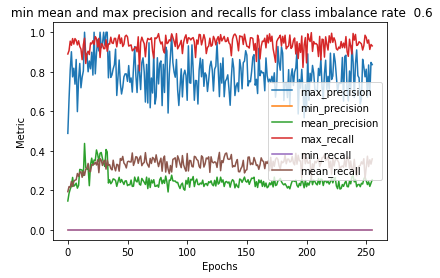

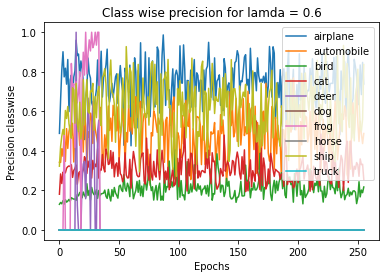

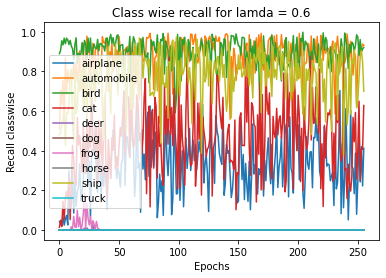

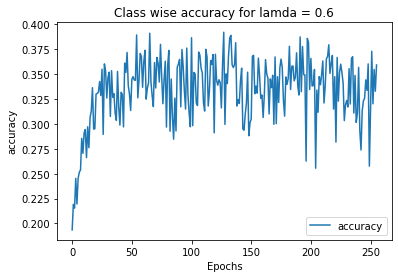

In [21]:
for log in logs_by_lamda_resnet34_cifar10:
    lamda = list(log.keys())[0]
    log_data = log[lamda]
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    print("=" * 30)
    print("THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER")
    print("THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES")
    print("THE VALUE OF LAMDA IS ", lamda)
    print("=" * 30)
    plot_log(log_data, lamda, num_classes=len(trainset.classes), classes=trainset.classes)

In [22]:
for log in logs_by_lamda_resnet34_cifar10:
    lamda = list(log.keys())[0]
    print("=" * 30 + "the lamda is = " + str(lamda) + "=" * 30)
    log_data = log[lamda]
    tabulate_metrics(log_data)

==============================the lamda is = 0.6==============================
MAX ACCURACU [E]  0.3921
MAX MEAN PRECISION [E]  0.4374044465887553
MAX MEAN RECALL [E]  0.3921
max E min C recall @ max E, C precision is :   0.0
max E min C precision @ max E, C recall is :   0.0


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Files already downloaded and verified
Files already downloaded and verified


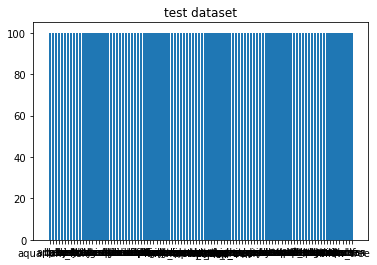

In [90]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([
    transforms.Resize(256, PIL.Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
trainset = long_tail(trainset, lamda)
show_data_distribution(testset, keyname="test dataset")

## RESNET 34 on CIFAR 10, transfer learning at 224

Files already downloaded and verified
Files already downloaded and verified
============================== showing data distribution for λ =  1.0 ==============================


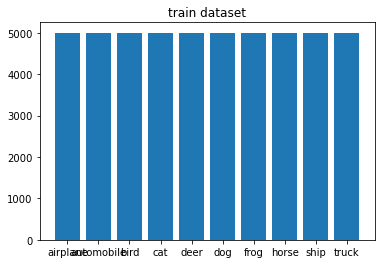

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


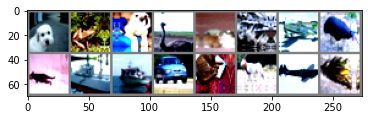

Using cache found in /home/harsh/.cache/torch/hub/pytorch_vision_v0.8.0


  dog  frog   dog  bird   cat  frog airplane  bird   cat  ship  ship automobile   cat  deer airplane  frog
length of trainset 50000
Finished Training Epoch : 0  With the running loss :  1.80601913608551
Finished testing
Finished Training Epoch : 1  With the running loss :  1.740523309936524
Finished testing
Finished Training Epoch : 2  With the running loss :  1.7356699654579166
Finished testing
Finished Training Epoch : 3  With the running loss :  1.7374544959831233
Finished testing
Finished Training Epoch : 4  With the running loss :  1.7377056419754022
Finished testing
Finished Training Epoch : 5  With the running loss :  1.7374934852790833
Finished testing
Finished Training Epoch : 6  With the running loss :  1.7390289281463631
Finished testing
Finished Training Epoch : 7  With the running loss :  1.7384417596435535
Finished testing
Finished Training Epoch : 8  With the running loss :  1.7359181602096545
Finished testing
Finished Training Epoch : 9  With the running loss :  1.72734

In [ ]:
import torchvision.transforms as transforms
import torch.optim as optim
import PIL


# Data transforms (normalization & data augmentation)

logs_by_lamda_resnet34_cifar10_tl= []

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

runs = 10
batch_size = 16

for lamda in [1.0, 0.9, 0.8, 0.6]:
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    trainset = long_tail(trainset, lamda)
    print("=" * 100)
    print("=" * 30 + " showing data distribution for λ = ", lamda , "=" * 30)
    show_data_distribution(trainset, keyname="train dataset")

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(batch_size)))
    print("length of trainset", len(trainset))
    net = Resnet34cifar(10, pretrained=True)
    if torch.cuda.is_available():
        net = net.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)

    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=256)
    logs_by_lamda_resnet34_cifar10_tl.append({lamda: logs})

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-34 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  1.0


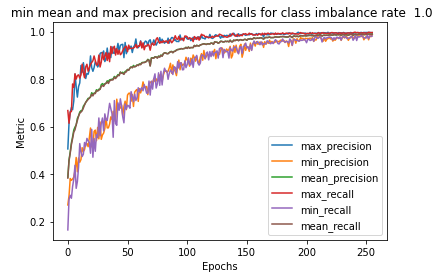

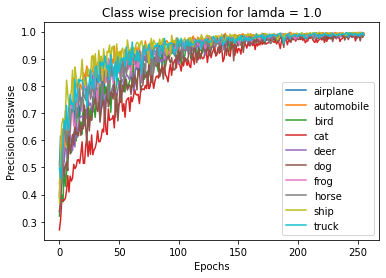

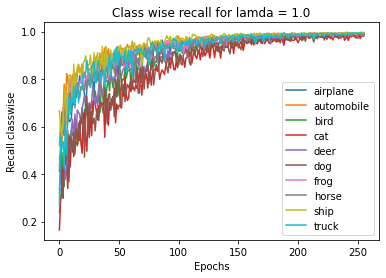

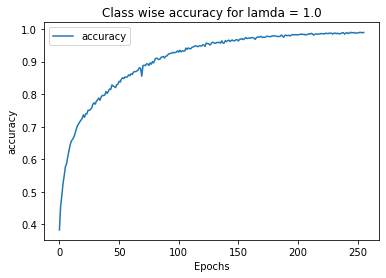

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-34 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.9


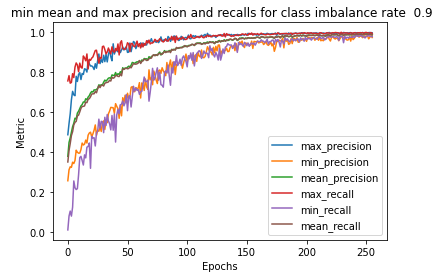

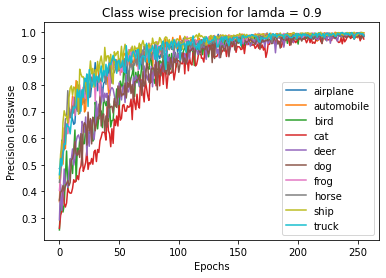

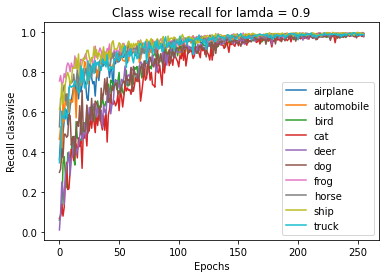

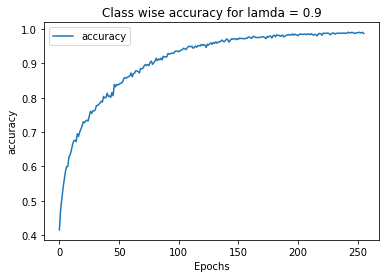

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-34 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.8


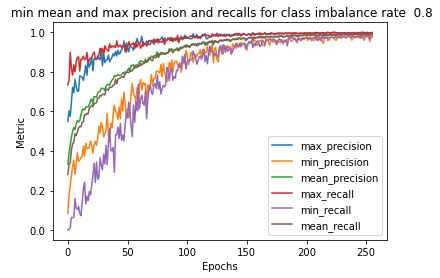

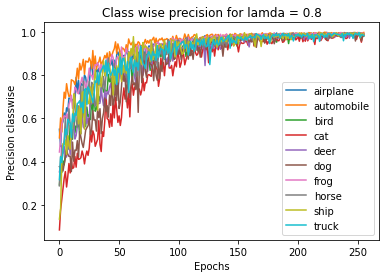

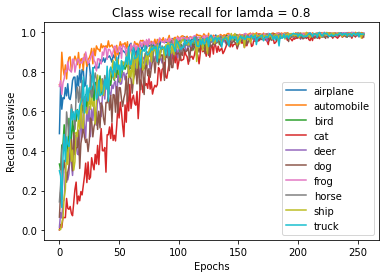

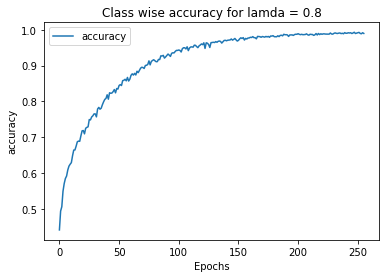

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-34 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.6


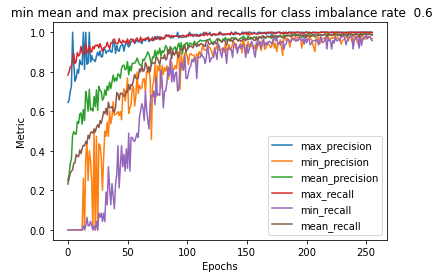

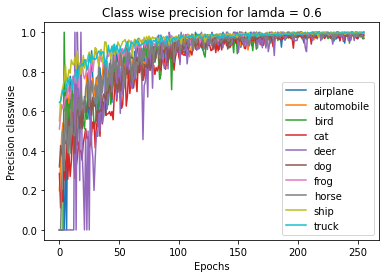

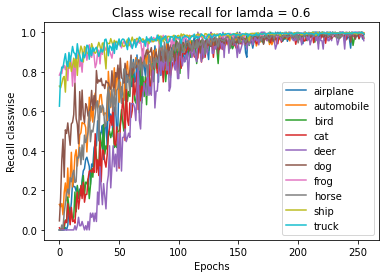

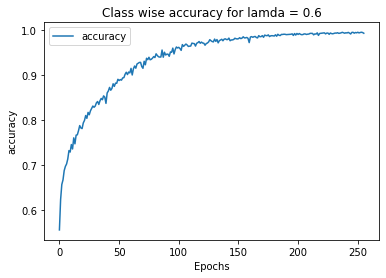

In [92]:
for log in logs_by_lamda_resnet34_cifar10:
    lamda = list(log.keys())[0]
    log_data = log[lamda]
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
    print("=" * 30)
    print("THIS IS THE RESULT OF TRAINING A RESNET-34 LAYER")
    print("THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES")
    print("THE VALUE OF LAMDA IS ", lamda)
    print("=" * 30)
    plot_log(log_data, lamda, num_classes=len(trainset.classes), classes=trainset.classes)

In [28]:
import torch.nn.functional as F

class LogitAdjustedLoss(torch.nn.Module):
    def __init__(self, priori, epsilon=0.001):
        super().__init__()
        '''
        weight (Tensor, optional) – a manual rescaling weight given to each class. 
                                    If given, has to be a Tensor of size C

        size_average (bool, optional) –     Deprecated (see reduction). By default, 
                                            the losses are averaged over each loss element 
                                            in the batch. Note that for some losses, there are 
                                            multiple elements per sample. If the field size_average
                                            is set to False, the losses are instead summed for
                                            each minibatch. Ignored when reduce is False. Default: True

        ignore_index (int, optional) –      Specifies a target value that is ignored
                                            and does not contribute to the input gradient.
                                            When size_average is True, the loss is averaged
                                            over non-ignored targets. Note that ignore_index
                                            is only applicable when the target contains class indices.

        reduce (bool, optional) –           Deprecated (see reduction). By default, the losses are
                                            averaged or summed over observations for each minibatch
                                            depending on size_average. When reduce is False, returns a
                                            loss per batch element instead and ignores size_average. Default: True

        reduction (string, optional) –      Specifies the reduction to apply to the output:
                                            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
                                            'mean': the weighted mean of the output is taken, 'sum': the
                                            output will be summed. Note: size_average and reduce are in
                                            the process of being deprecated, and in the meantime, specifying
                                            either of those two args will override reduction. Default: 'mean'

        label_smoothing (float, optional) – A float in [0.0, 1.0]. Specifies the amount of smoothing when
                                            computing the loss, where 0.0 means no smoothing. The targets 
                                            become a mixture of the original ground truth and a uniform
                                            distribution as described in Rethinking the Inception Architecture
                                            for Computer Vision. Default: 0.00.0.
        '''
        self.epsilon = epsilon
        
        # here we make sure that there is a non zero priori for even 
        # those classes which happen to have zero samples (by mistake)
        self.priori = (priori + epsilon)/torch.sum(priori + epsilon)
        self.priori.requires_grad = False
        self.CrossEntropyLoss = torch.nn.CrossEntropyLoss()
    def forward(self, x, y):
        x_logit_adjusted = x - torch.log(self.priori)
        loss = self.CrossEntropyLoss(x_logit_adjusted, y)
        return loss

In [29]:
import random 
import numpy as np
def test_loss():
    batch_size = np.random.randint(2, 3)
    pred_size = np.random.randint(5, 10)
    
    y = torch.tensor(np.random.randint(0, pred_size, batch_size))
    x = torch.randn((batch_size, pred_size))

    priori = F.softmax(torch.randn((pred_size)), dim=0)
    LA = LogitAdjustedLoss(priori=priori, epsilon = 1e-6)

    y_oh = F.one_hot(y, pred_size)
    loss_all_logits = -1*torch.log(F.softmax(x-torch.log(priori)))

    calc_LA = torch.mean(torch.sum(y_oh * loss_all_logits, dim=-1))

    if torch.abs(calc_LA - LA(x, y)) < 0.01:
        print("the calculate logit adjusted loss is within error bounds with abs difference", torch.abs(calc_LA - LA(x, y)))
    else:
        print("the estimate is too inaccurate  ", torch.abs(calc_LA - LA(x, y)))
    return 

test_loss()

the calculate logit adjusted loss is within error bounds with abs difference tensor(2.4796e-05)


/home/harsh/anaconda3/envs/constrained_optimisation/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Files already downloaded and verified
Files already downloaded and verified
the per class priori is as follows
apple  :  0.0033153061235089406
aquarium_fish  :  0.009103740110148249
baby  :  0.009869963540532718
bear  :  0.005837051383296836
beaver  :  0.019616836611053574
bed  :  0.007289650115274102
bee  :  0.01007139136789053
beetle  :  0.0042248444862115235
bicycle  :  0.011838069004606213
bottle  :  0.003120339600997627
bowl  :  0.00714385711296862
boy  :  0.01635549362453871
bridge  :  0.00856836736175065
bus  :  0.005605904148518281
butterfly  :  0.0047692959576971835
camel  :  0.004311065802256657
can  :  0.020017180215360794
castle  :  0.004580431837772374
caterpillar  :  0.006201764765634257
cattle  :  0.008229060014225324
chair  :  0.006589266340591778
chimpanzee  :  0.013096356502156554
clock  :  0.018463209683630737
cloud  :  0.0048666285282624325
cockroach  :  0.013914649191829675
couch  :  0.006077729470321571
crab  :  0.008064478813940817
crocodile  :  0.005493786065547

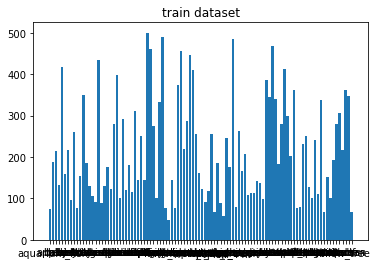

In [30]:
import random

def long_tail_priori(dataset, classes=10, lamda=1):
    class_indices = list(range(classes))
    random.shuffle(class_indices)
    class_probs = [lamda ** x for x in class_indices]
    priori = [x/sum(class_probs) for x in class_probs]
    select_list = []
    for i, (img, label) in enumerate(dataset):
        if np.random.binomial(1, class_probs[label]):
            select_list.append(i)
    dataset.data=dataset.data[np.array(select_list)]
    dataset.targets=list(dataset.targets[x] for x in select_list)
    return dataset, priori

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = trainset.classes


imbalanced_trainset, priori = long_tail_priori(trainset, classes=len(trainset.classes), lamda = 0.98)
print("the per class priori is as follows")
for i, elem in enumerate(imbalanced_trainset.classes):
    print(elem, " : " , priori[i])
show_data_distribution(imbalanced_trainset, keyname="train dataset")

In [80]:
import torchvision.transforms as transforms
import torch.optim as optim
import PIL

logs_by_lamda_resnet18_cifar100_LA = []

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])


batch_size = 256

for lamda in [1.0, 0.995, 0.985, 0.975, 0.965, 0.955]:
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)
    trainset, priori = long_tail_priori(trainset, len(trainset.classes), lamda)
    print("=" * 30 + " showing data distribution for λ = ", lamda , "=" * 30)
    show_data_distribution(trainset, keyname="train dataset")

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=8)

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(batch_size)))
    print("length of trainset", len(trainset))

    net = Resnet18cifar(100, pretrained=False)
    if torch.cuda.is_available():
        net = net.cuda()
    criterion = LogitAdjustedLoss(priori=torch.tensor(priori).cuda())
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    logs = loop(trainloader, testloader, net, optimizer, criterion, epochs=256)
    logs_by_lamda_resnet18_cifar100_LA.append({lamda: logs})

Files already downloaded and verified
Files already downloaded and verified
============================== showing data distribution for λ =  1.0 ==============================


KeyboardInterrupt: 

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  1.0


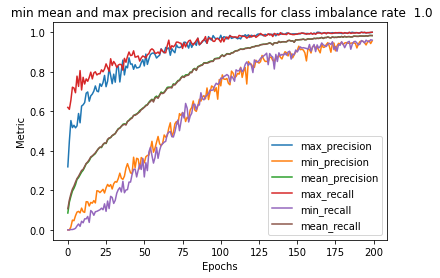

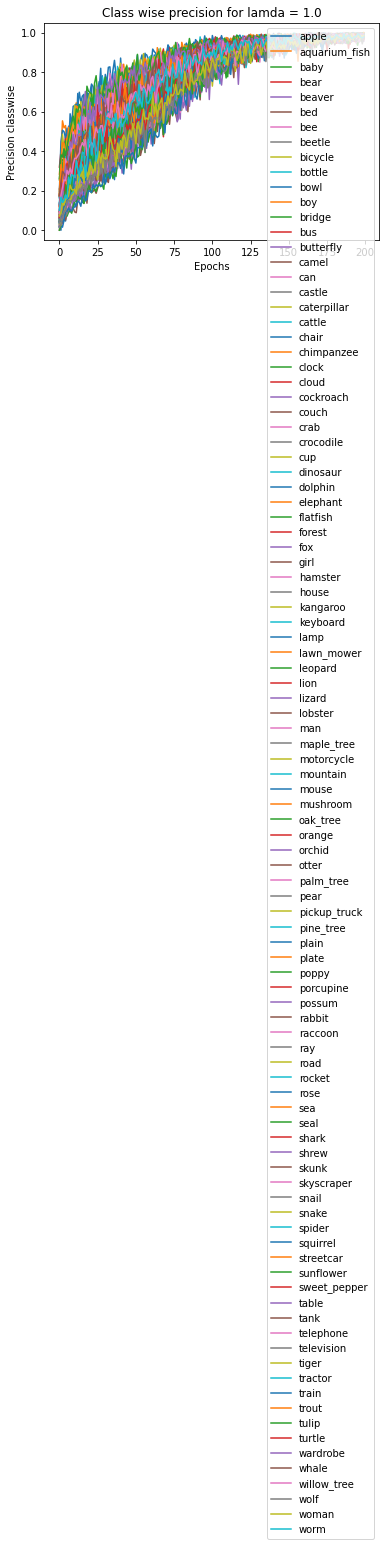

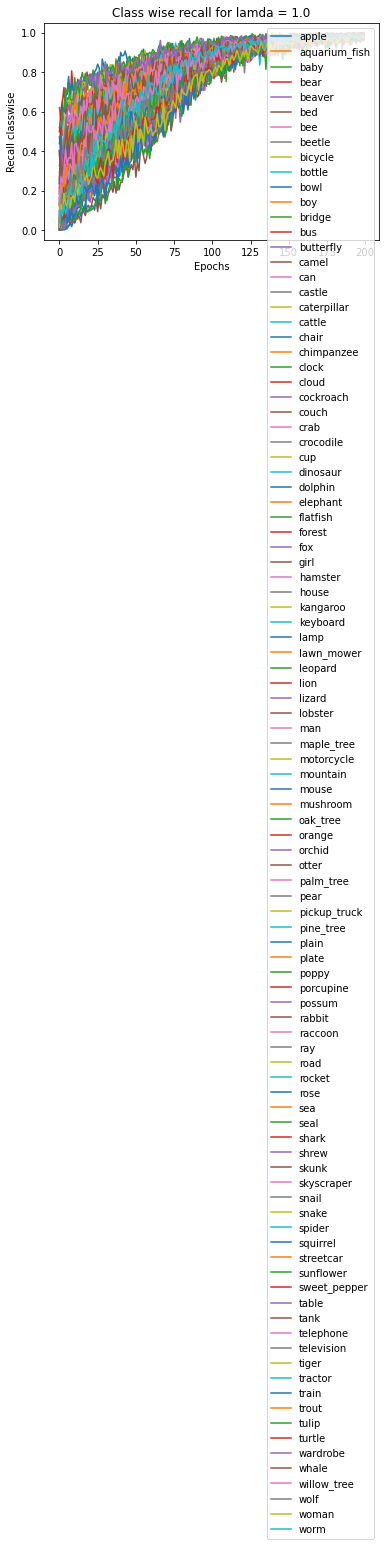

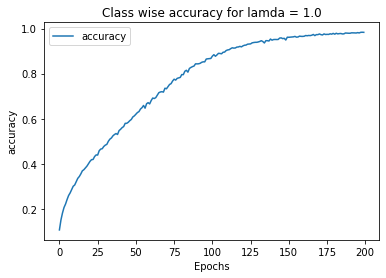

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.995


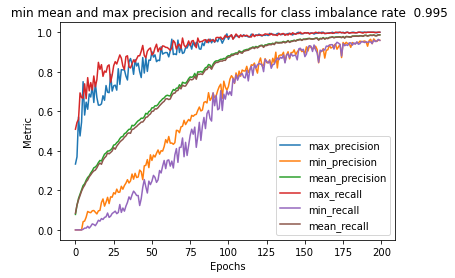

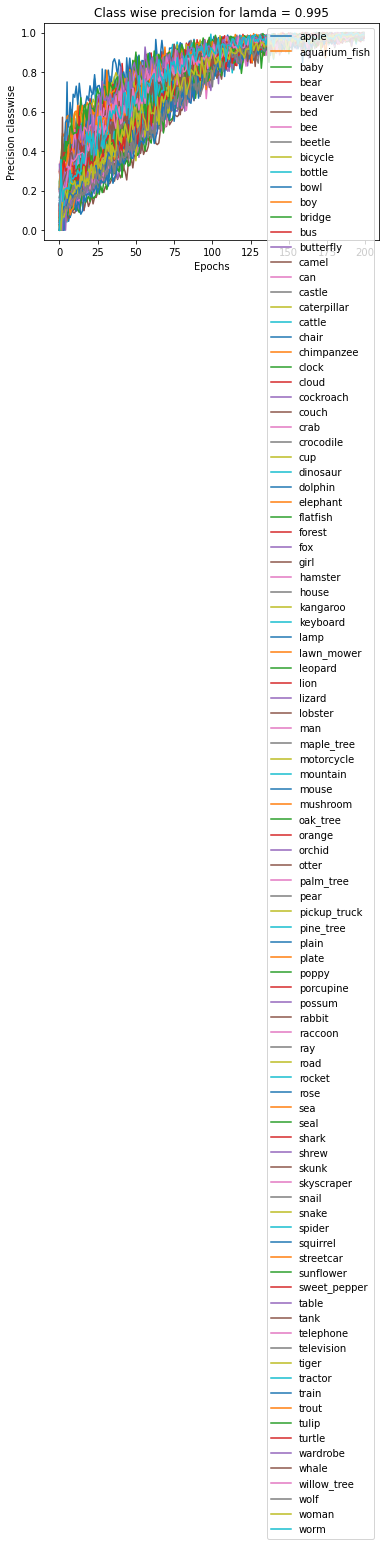

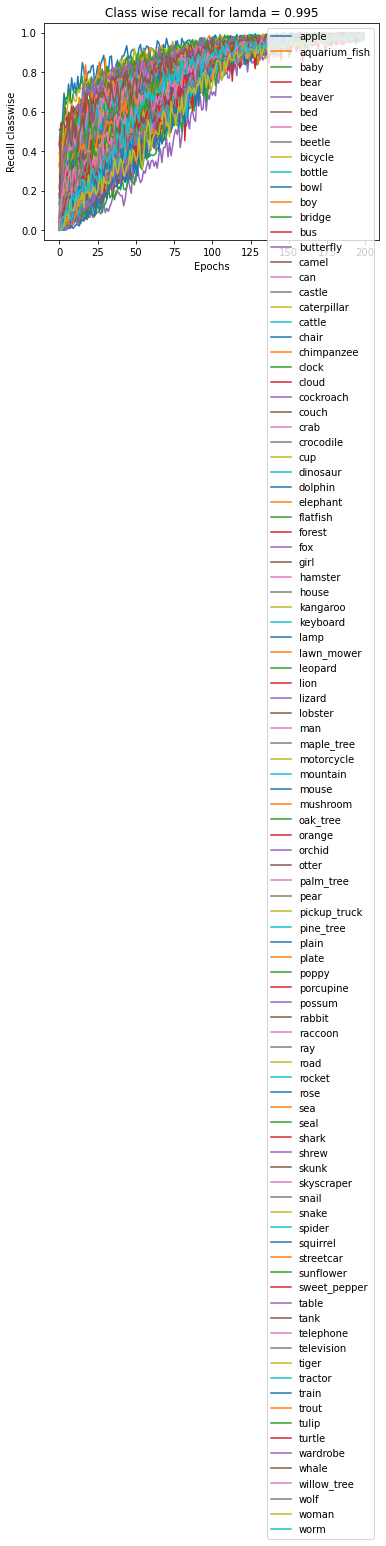

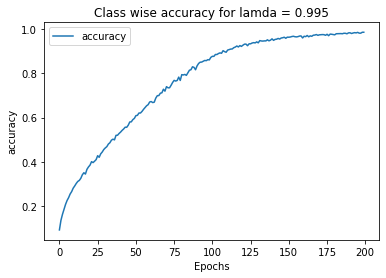

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.985


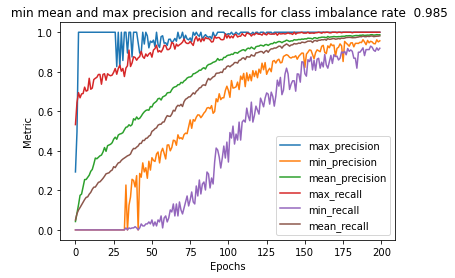

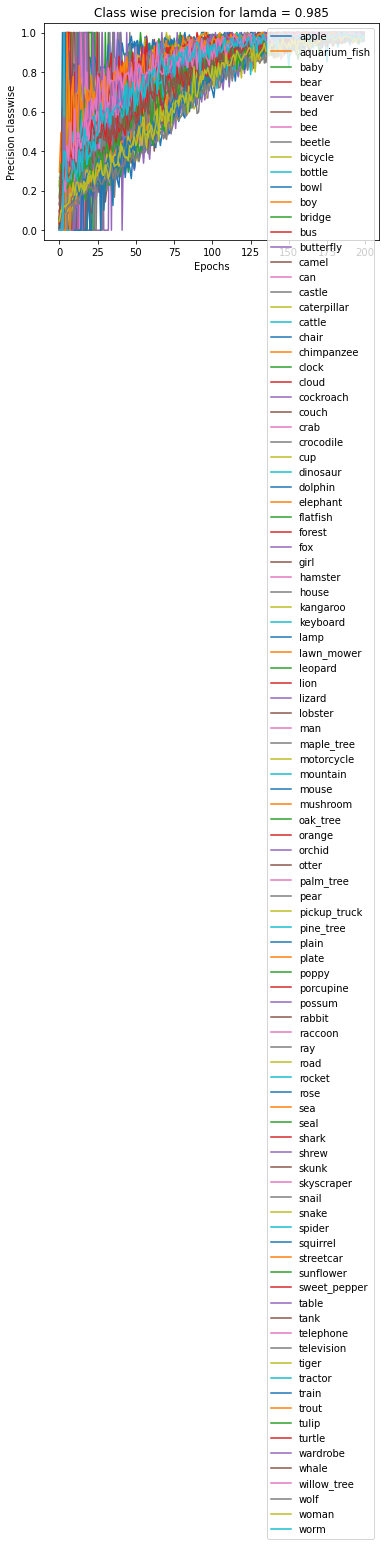

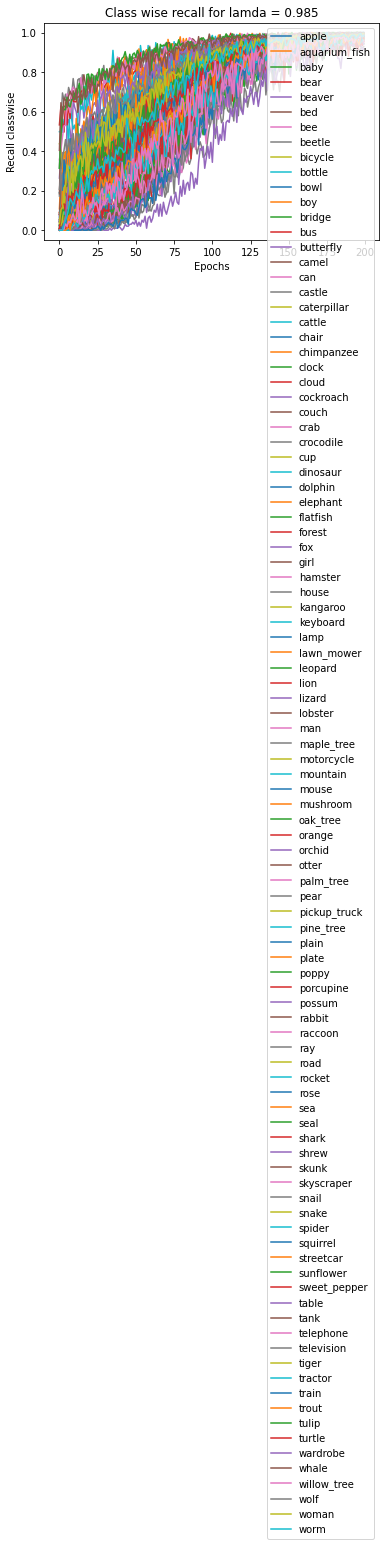

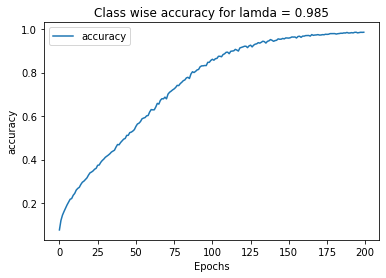

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.975


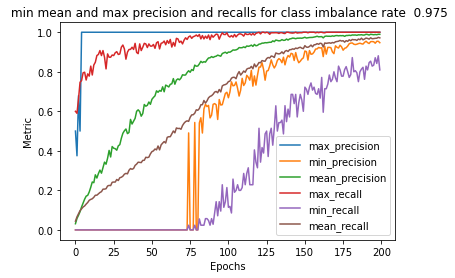

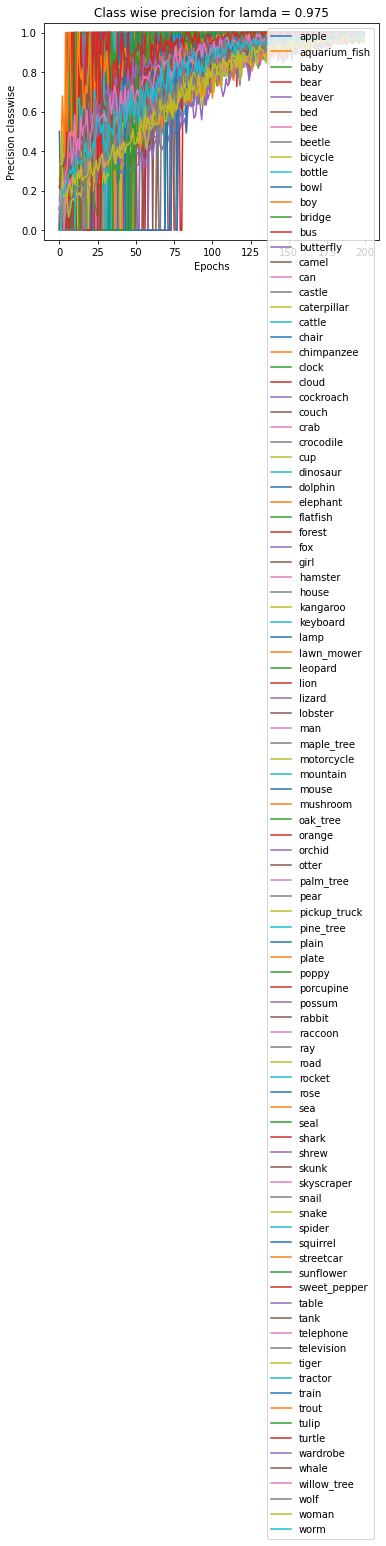

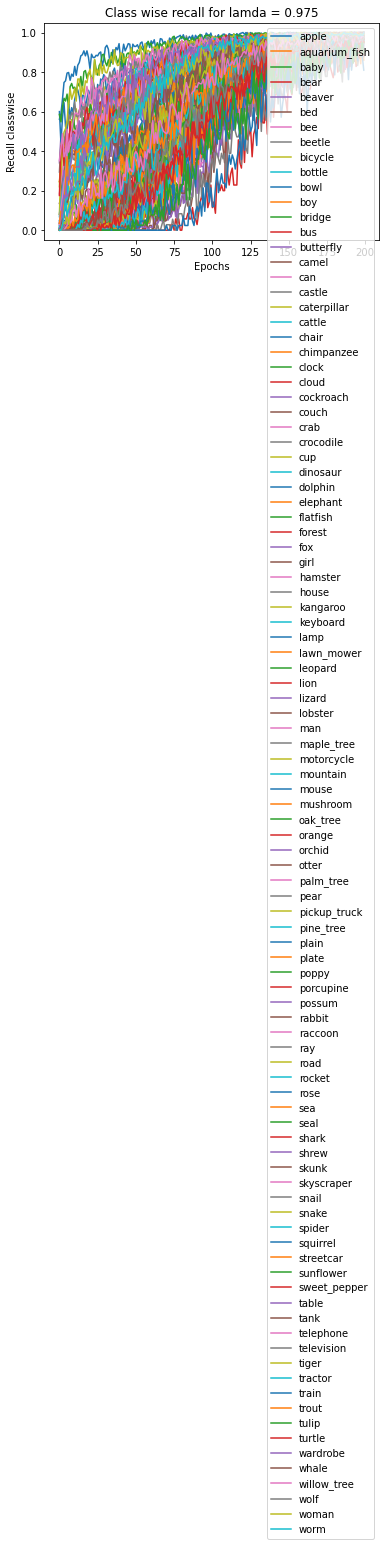

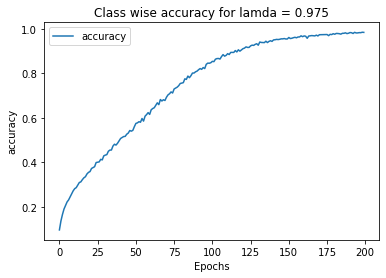

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.965


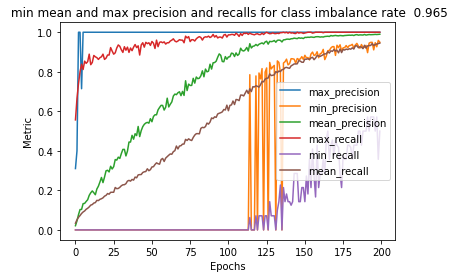

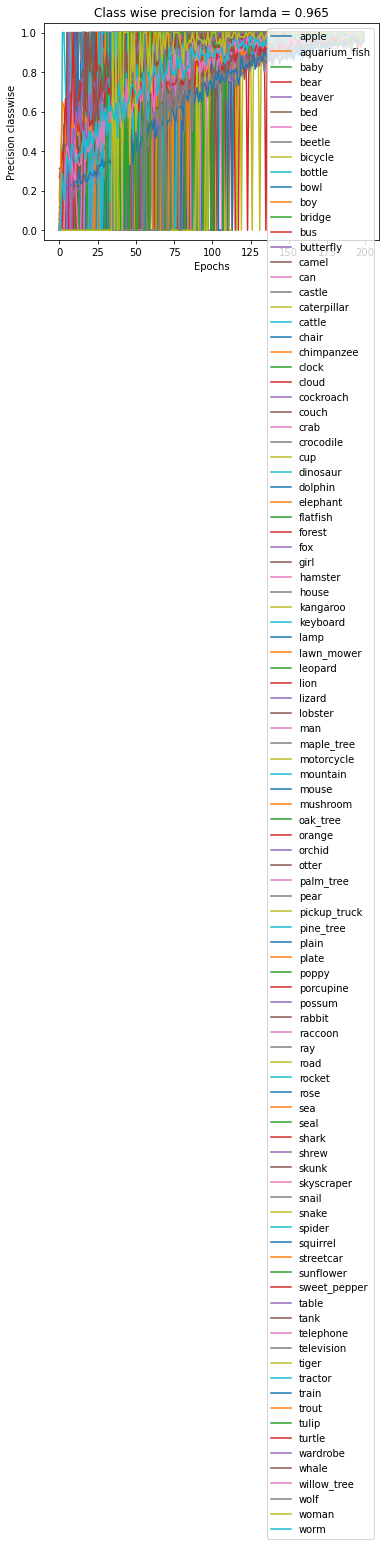

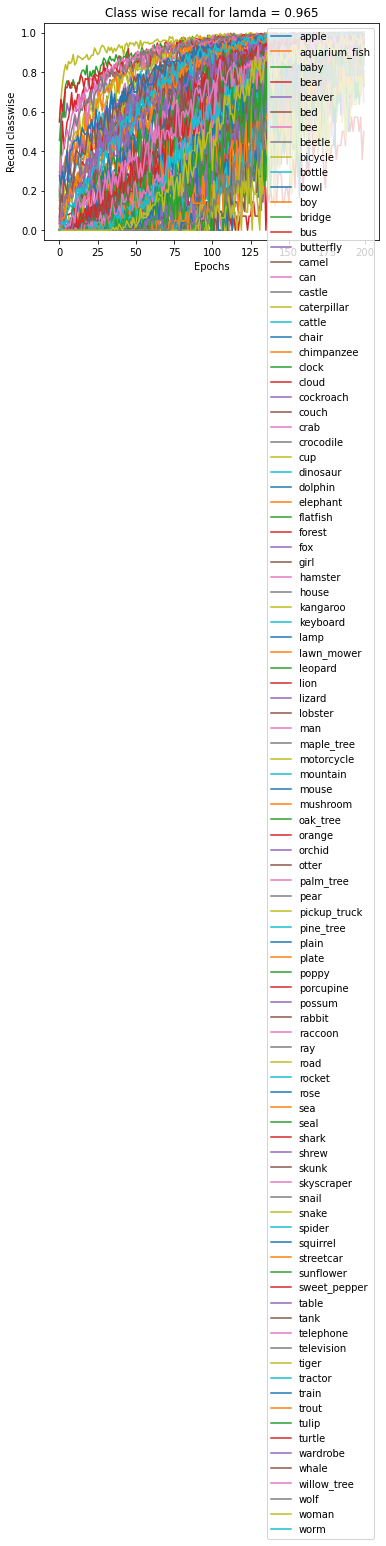

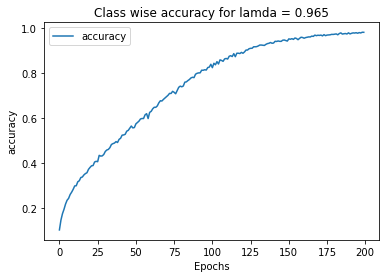

Files already downloaded and verified
THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER
THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES
THE VALUE OF LAMDA IS  0.955


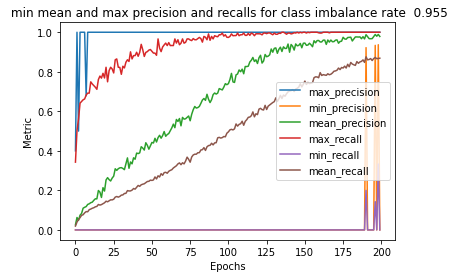

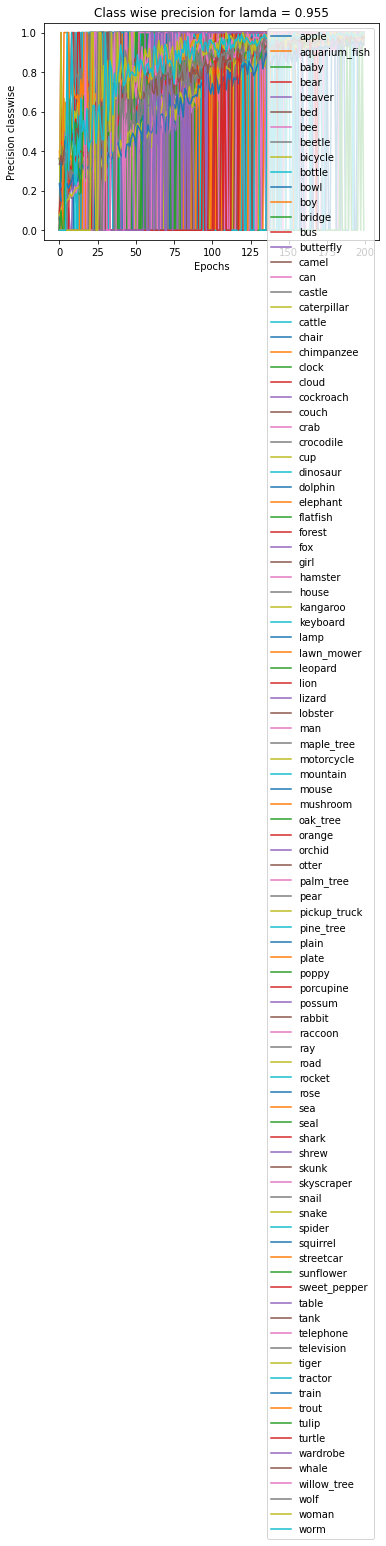

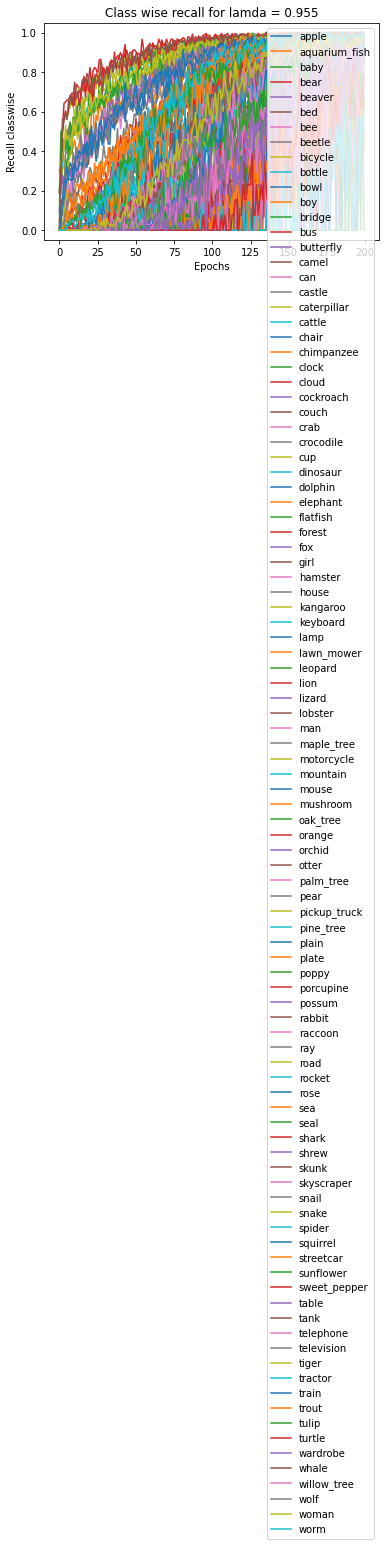

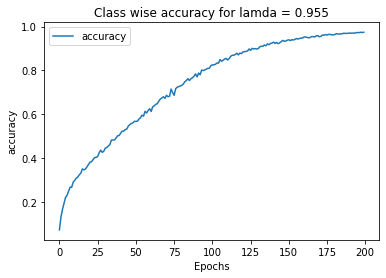

In [36]:
for log in logs_by_lamda_resnet18_cifar100_LA:
    lamda = list(log.keys())[0]
    log_data = log[lamda]
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
    print("=" * 30)
    print("THIS IS THE RESULT OF TRAINING A RESNET-18 LAYER")
    print("THE MODEL WAS NOT PRETRAINED ON IMAGENET-1K CLASSES")
    print("THE VALUE OF LAMDA IS ", lamda)
    print("=" * 30)
    plot_log(log_data, lamda, num_classes=len(trainset.classes), classes=trainset.classes)

The metrics we need to tabulate are as follows:
1. max precision [E, C]
2. max recall [E, C]
3. max recall [E, C] @ max precision [E, C]
4. max mean recall [E]
5. max mean precision [E]
6. max accuracy [E]

In [50]:
def tabulate_metrics(logs):
    precision = [x['precision'] for x in logs]

    recall = [x['recall'] for x in logs]

    accuracy = [x['accuracy'] for x in logs]
    print("MAX ACCURACU [E] ", max(accuracy))

    len_logs = len(accuracy)

    max_precision = [x['max_precision'] for x in logs]
    print("MAX PRECISION [E, C] ", max(max_precision))

    min_precision = [x['min_precision'] for x in logs]
    mean_precision = [x['mean_precision'] for x in logs]

    max_recall = [x['max_recall'] for x in logs]
    print("MAX RECALL [E, C] ", max(max_recall))

    min_recall = [x['min_recall'] for x in logs]
    mean_recall = [x['mean_recall'] for x in logs]

    maxEC_p = max([x['max_precision'] for x in logs])
    maxEminC_r_at_max_pEC = max([min_recall[index] for index, elem in enumerate(max_precision) if elem == maxEC_p])
    print("max E min C recall @ max E, C precision is :  ", maxEminC_r_at_max_pEC)

    maxEC_r = max([x['max_recall'] for x in logs])
    maxEminC_p_at_max_rEC = min([min_precision[index] for index, elem in enumerate(max_recall) if elem == maxEC_r])
    print("max E min C precision @ max E, C recall is :  ", maxEminC_p_at_max_rEC)
    
    return
    
for log in logs_by_lamda_resnet18_cifar100_LA:
    lamda = list(log.keys())[0]
    print("=" * 30 + " the lamda is = " + str(lamda) + "=" * 30)
    log_data = log[lamda]
    tabulate_metrics(log_data)

============================== the lamda is = 1.0==============================
MAX ACCURACU [E]  0.98354
MAX PRECISION [E, C]  1.0
MAX RECALL [E, C]  1.0
max E min C recall @ max E, C precision is :   0.96
max E min C precision @ max E, C recall is :   0.9426386233269598
============================== the lamda is = 0.995==============================
MAX ACCURACU [E]  0.9867712776762136
MAX PRECISION [E, C]  1.0
MAX RECALL [E, C]  1.0
max E min C recall @ max E, C precision is :   0.9636871508379888
max E min C precision @ max E, C recall is :   0.9141630901287554
============================== the lamda is = 0.985==============================
MAX ACCURACU [E]  0.9848408482921723
MAX PRECISION [E, C]  1.0
MAX RECALL [E, C]  1.0
max E min C recall @ max E, C precision is :   0.9298245614035088
max E min C precision @ max E, C recall is :   0.8519362186788155
============================== the lamda is = 0.975==============================
MAX ACCURACU [E]  0.9851414836665574
MAX PREC